In [23]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import os
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

In [11]:
# I don't know if we can use the GPUs on DSMLP to utilize the CUDA function of Pytorch
# So do not set epoch too high in order to have a faster training process.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [12]:
# create varaibles that holds a dataframe
cwd = os.getcwd()
data_dir = os.path.join(cwd, "Data/")
data_files = [f for f in os.listdir(str(data_dir)) if f.endswith('csv')]

data_train_name = [f for f in data_files if 'TRAIN' in f]
data_test_name = [f for f in data_files if 'TEST' in f]

train_df = pd.read_csv(os.path.join(data_dir,data_train_name[0]))
test_df = pd.read_csv(os.path.join(data_dir,data_test_name[0]))
train_df = train_df.dropna()
test_df = test_df.dropna()


# feature selection and renaming

def manipulate_cols(df):
    boolean_col = ['highavse','lowavse','truedcr','lq']
    useless_col = ['tdrift50','tdrift10']
    new_df = df.drop(columns=boolean_col+['id']+useless_col)
    new_df.columns = [col.strip().replace(' ','_') for col in new_df.columns]
    return new_df

train_df = manipulate_cols(train_df)
test_df = manipulate_cols(test_df)




# Reshaping for consistency
X_train = train_df.drop(columns=['energylabel']).values
X_test = test_df.drop(columns=['energylabel']).values
y_train = train_df['energylabel'].values.reshape(-1,1)
y_test = test_df['energylabel'].values.reshape(-1,1)

In [13]:
#####################################################################################
# Extremely Important: REMOVE "pass" and UNCOMMENT the codes below to RUN it !!!!!  #
#####################################################################################

#---------------------------------------------------------------------------
# NaN Will Ruin the NN! So make sure it desn't contain any NaN in any corner!
#---------------------------------------------------------------------------

"""
features = [
    'tdrift', 'rea', 'dcr', 'peakindex', 'peakvalue', 'tailslope',
    'currentamp', 'lfpr', 'lq80', 'areagrowthrate', 'inflection_point',
    'risingedgeslope'
]
print(train_df[features].std())
print("Any NaNs in X_train?", np.isnan(X_train).any())
print("Any NaNs in X_test?", np.isnan(X_test).any())
print('\n')
print(train_df.isnull().sum())
print(test_df.isnull().sum())
"""
pass

In [14]:
# Standardization

scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

scaler_y = StandardScaler() # VERY IMPORTANT! We also need to transform it back to original after prediction!
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)


In [15]:
# Convert to Pytorch Tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [16]:
# Define dataloader

class NPDL(Dataset): # Neutrino Physics Deel Learning
    def __init__(self,X,y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self,idx):
        return self.X[idx], self.y[idx]
    
train_NPDL = NPDL(X_train_tensor,y_train_tensor)
test_NPDL = NPDL(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_NPDL, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_NPDL, batch_size=batch_size, shuffle=False)

In [17]:
# Public Static int main!

class SuperPredictor(nn.Module):
    def __init__(self, input_size):
        super(SuperPredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)  
        self.out = nn.Linear(16, 1)
        
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))  
        x = self.out(x)
        return x
    
input_size = X_train.shape[1]
model = SuperPredictor(input_size).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


    

In [20]:
# Set epoch to 100 is good, but my computer is trash. DSMLP with c8m32 is even 10x slower than my laptop :)
num_epochs = 30 

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * X_batch.size(0)
    
    train_loss = running_loss / len(train_NPDL)
    
    model.eval()
    with torch.no_grad():
        ######################################################################################
        # Evaluate on test set, only for tuning things like learning rates and batchsizes.    #
        ######################################################################################
        test_predictions = model(X_test_tensor)
        test_loss_val = criterion(test_predictions, y_test_tensor).item()
        
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Test Loss(For tuning): {test_loss_val:.4f}")



model.eval()
with torch.no_grad():
    X_test_device = X_test_tensor.to(device)
    y_test_device = y_test_tensor.to(device)
    predictions = model(X_test_device)
    
    final_test_loss = criterion(predictions, y_test_device).item()
    print(f"Final Test MSE (scaled): {final_test_loss:.4f}")


predictions_np = predictions.cpu().numpy()  
y_test_np      = y_test_device.cpu().numpy()

predictions_original = scaler_y.inverse_transform(predictions_np)
y_test_original      = scaler_y.inverse_transform(y_test_np)

MSE = mean_squared_error(y_test_original, predictions_original)
MAE = mean_absolute_error(y_test_original, predictions_original)
r2  = r2_score(y_test_original, predictions_original)

print(f"Final Results on Test Data:")
print(f"MSE: {MSE:.4f}")
print(f"MAE: {MAE:.4f}")
print(f"R^2: {r2:.4f}")

      

Epoch [1/30] Train Loss: 0.0043, Test Loss(For tuning): 0.0046
Epoch [2/30] Train Loss: 0.0041, Test Loss(For tuning): 0.0042
Epoch [3/30] Train Loss: 0.0039, Test Loss(For tuning): 0.0041
Epoch [4/30] Train Loss: 0.0038, Test Loss(For tuning): 0.0043
Epoch [5/30] Train Loss: 0.0037, Test Loss(For tuning): 0.0041
Epoch [6/30] Train Loss: 0.0037, Test Loss(For tuning): 0.0039
Epoch [7/30] Train Loss: 0.0036, Test Loss(For tuning): 0.0040
Epoch [8/30] Train Loss: 0.0035, Test Loss(For tuning): 0.0036
Epoch [9/30] Train Loss: 0.0035, Test Loss(For tuning): 0.0037
Epoch [10/30] Train Loss: 0.0034, Test Loss(For tuning): 0.0037
Epoch [11/30] Train Loss: 0.0034, Test Loss(For tuning): 0.0037
Epoch [12/30] Train Loss: 0.0033, Test Loss(For tuning): 0.0036
Epoch [13/30] Train Loss: 0.0033, Test Loss(For tuning): 0.0036
Epoch [14/30] Train Loss: 0.0033, Test Loss(For tuning): 0.0036
Epoch [15/30] Train Loss: 0.0031, Test Loss(For tuning): 0.0038
Epoch [16/30] Train Loss: 0.0032, Test Loss(For t

Here we can see that MSE is the lowest out of all our models, this may be our best performing model.

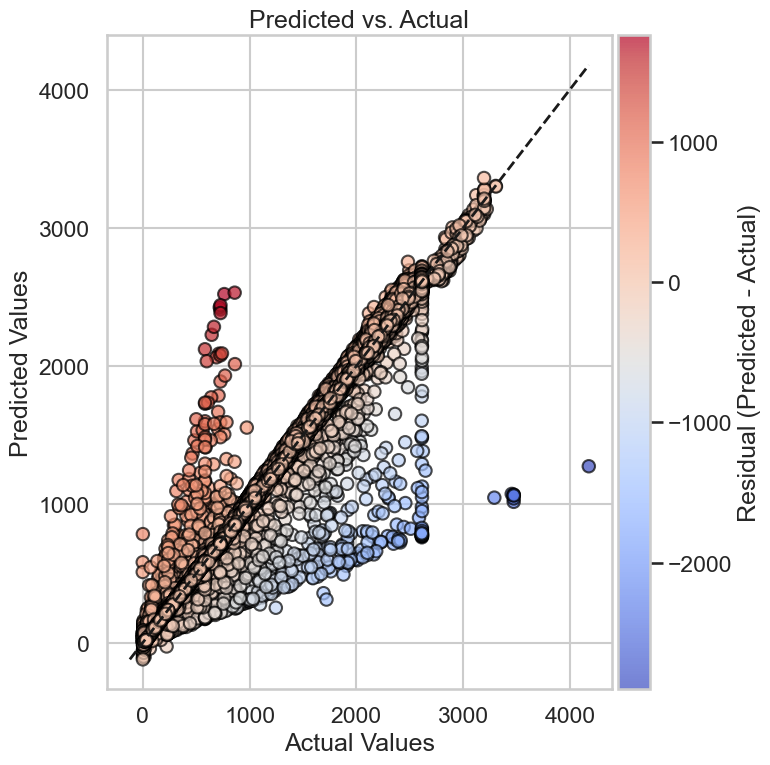

In [29]:

residuals = predictions_original.flatten() - y_test_original.flatten()

sns.set_style("whitegrid")   
sns.set_context("talk")      
plt.figure(figsize=(8, 8))

scatter = plt.scatter(
    x=y_test_original.flatten(),
    y=predictions_original.flatten(),
    c=residuals,              
    cmap="coolwarm",          
    alpha=0.7,                
    edgecolors="black",
    s=80                      
)

cbar = plt.colorbar(scatter, pad=0.01)
cbar.set_label("Residual (Predicted - Actual)")

# 45-degree reference line for perfect predictions
min_val = min(y_test_original.min(), predictions_original.min())
max_val = max(y_test_original.max(), predictions_original.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2)

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. Actual")

plt.tight_layout()
plt.savefig("NN_Predicted_vs_Actual.png", dpi=300, bbox_inches="tight")
plt.show()


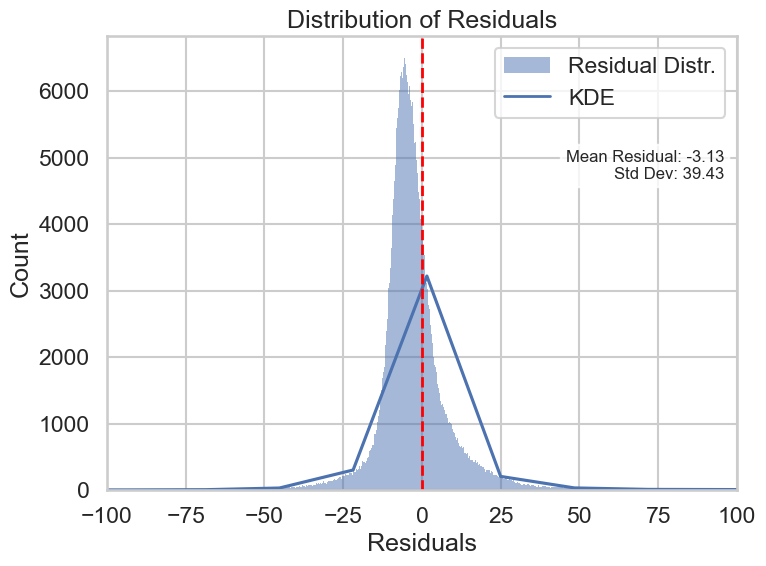

In [30]:
sns.set(style="whitegrid", context="talk")
residuals = predictions_original.flatten() - y_test_original.flatten()
# mean and std of residuals
residual_mean = np.mean(residuals)
residual_std = np.std(residuals)

sns.set(style="whitegrid", context="talk")

plt.figure(figsize=(8, 6))

sns.histplot(residuals, kde=True, label="Residual Distr.")

dashed_line = mlines.Line2D(
    [], [], 
    color="#4C72B0",  # match Seaborn's default blue
    linestyle="-",
    linewidth=2,
    label="KDE Dashed"
)

handles, labels = plt.gca().get_legend_handles_labels()
handles.append(dashed_line)
labels.append("KDE")

plt.legend(handles, labels, loc="upper right")

plt.axvline(0, color='red', linestyle='--', linewidth=2)
plt.xlim(-100, 100)
plt.xlabel("Residuals")
plt.title("Distribution of Residuals")
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
textstr = (f"Mean Residual: {residual_mean:.2f}\n"
           f"Std Dev: {residual_std:.2f}")
plt.text(0.98, 0.75, textstr, transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top', horizontalalignment='right',
         bbox=props)

plt.tight_layout()
plt.savefig("NN_Distribution_Residual", dpi=300, bbox_inches="tight")
plt.show()


In [1]:
#len(residuals)

NameError: name 'residuals' is not defined

In [82]:
#np.save("NN_result.npy", residuals)